### Importing required packages 

In [13]:
import nltk
import pandas as pd
import re
from collections import Counter
import time
import numpy as np
import PyDictionary
import json
import itertools
import warnings
warnings.filterwarnings("ignore")
import PyDictionary
from IPython.display import Image

### Retrieving the Synonyms of a Word from OXFORD thesaurus dictionaries with the use of Rest API 

In [2]:
import requests
import json

app_id = '96612f3b'
app_key = 'dc9b1d7ab5ec44eca4ea60507126bdae'

language = 'en'
word_id = 'eat'

url = 'https://od-api.oxforddictionaries.com:443/api/v1/entries/' + language + '/' + word_id.lower() + '/synonyms'

r = requests.get(url, headers = {'app_id': app_id, 'app_key': app_key})

#print("code {}\n".format(r.status_code))
#print("text \n" + r.text)
#print("json \n" + json.dumps(r.json()))

### Oxford Thesaurus Dictionary can define the word in different ways 
####  Strong Synonyms : which can define very close Meaning of asked word, All Synonyms can give all relative possibilties of a asked word. We can use these closeness words, all synonyms,all antonyms  and antonyms as a features of a asked word in reviewing the sentence.

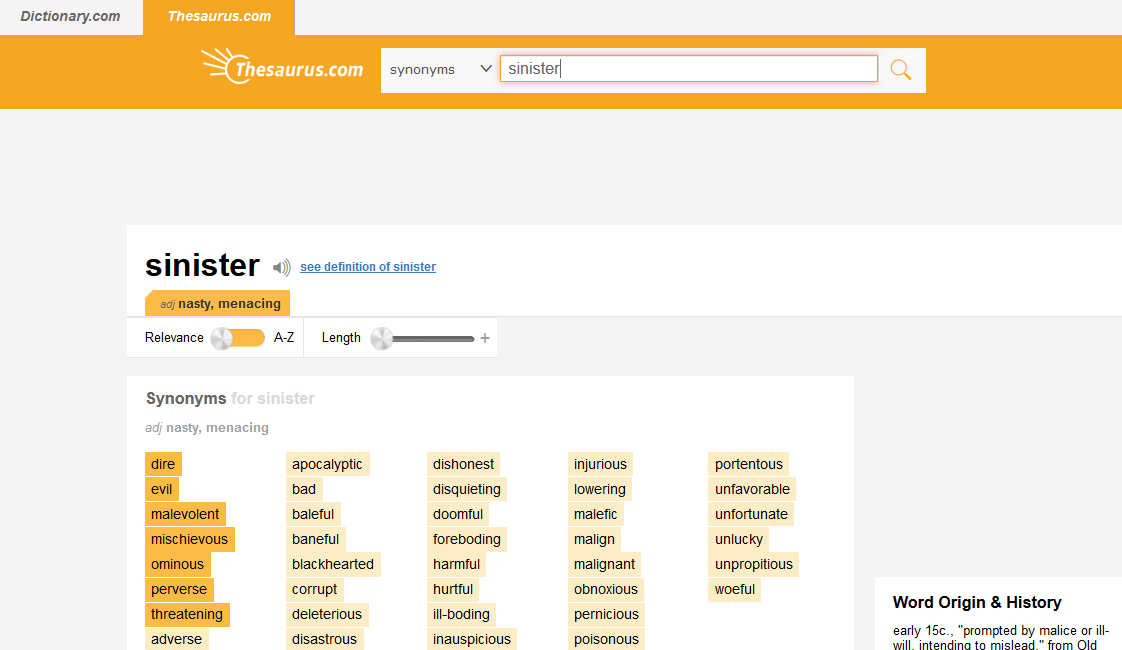

In [7]:
Image(filename='thesaurus.PNG',width=800)

In [8]:
# retrieving the Synonyms and Antonyms of a asked word 'eat'
da = r.json()['results'][0]['lexicalEntries'][0]['entries'][0]['senses'][0]['subsenses'][0]
try:
    if da['registers'][0] == 'informal':
        #print(da['synonyms'])
        print('informal')
        for i in (da['synonyms']):
            print(i['text'])
except:
    for i in (da['synonyms']):
            print(i['text'])
    

swallow
chew
munch
chomp
champ


### Words representing the possible sentiments of Natural Language
        

### The words selection should be based on the application.

    If the Word Features are required for the Review Classification, then review related sentiment words should be chosen.
    If the Word Features are required for the Language modelling, then All sentiment commands given for the model should be chosen for the Feature words

In [9]:
Dictionary =  PyDictionary.PyDictionary()
Negative_Features = ['Apathy','Atrocious','Bemoan','Cold-hearted','Deplorable','Despicable','Detrimental',
                     'Dreadful','Ghastly','Grotesque','Gruesome','Hard-hearted','Insidious','Insipid',
                     'Malicious','Monstrous','Noxious','Offensive','Oppressive','Pessimistic','Prejudice',
                     'Repulsive','Ruthless','Sinister','Vice','Vicious','Vile','Villainous','Vindictive']
Negative_Features = list(map(lambda x: x.lower(),Negative_Features))

In [10]:
word_in = 'Apathy'
syns = Dictionary.synonym(word_in)
count = 0
while syns is None and count <10:
    syns = Dictionary.synonym(word_in)
    count = count + 1

    

Apathy has no Synonyms in the API
Apathy has no Synonyms in the API
Apathy has no Synonyms in the API
Apathy has no Synonyms in the API
Apathy has no Synonyms in the API
Apathy has no Synonyms in the API
Apathy has no Synonyms in the API
Apathy has no Synonyms in the API
Apathy has no Synonyms in the API
Apathy has no Synonyms in the API
Apathy has no Synonyms in the API


## Retrieving the Synonyms from the PyDictionary in Python

- The Pydicionary Package in Python internally uses the Thesaurus Url and word synonyms page is downloaded through Pydictionary package.

- The Downloaded page with respect to Synonyms or Antonyms is feed to Beautiful soup package which will extract all Synonyms and Antonyms from the downloaded page Text 

The below Code Finds the Synonyms1 for one word, For that synonyms1 next synonyms2 will be searched This way the process will be continued to Fetch all the relative words of mentioned word. The stages of word synonyms will be given with the score for each stage to point how relative the word is. 

In [ ]:
t1 = time.time()
word = 'Apathy'
temp_df = pd.DataFrame(columns= [word,'word'])
syns = Dictionary.synonym(word)
while syns is None:
    syns = Dictionary.synonym(word)
    
temp_list1 = syns
temp_list2 = []
words = []
score = []
words.extend(syns)
score.extend(np.repeat(1,len(syns)))
print('stage -1')
print(temp_list1)

# Looping the dataframe to 
for i in range(1):
    print('loop',i)
    
    for j in temp_list1:
        
        if j not in words:
            print('inner')
            word_in = j.split(' ')[0]
            syns = Dictionary.synonym(word_in)
            count = 0
            while syns is None:
                syns = Dictionary.synonym(word_in)
            if syns is not None:
                temp_list2.extend(syns)

    words.extend(temp_list2)
    score.extend(np.repeat(1-0.005*i,len(temp_list2)))
    temp_list1 = temp_list2

    
    
#     syns = Dictionary.synonym(word)
#     while temp is None:
#         syns = Dictionary.synonym(word)
print(time.time()-t1)    
    

In [3]:
def Json_data(x,word_feature):
    '''
    Function to extract the different types of information from Json data of word`
    
    '''
    if word_feature == 'synonyms':
        j_val = 'swds'
    elif word_feature =='meaning':
        j_val = 'sdsc'
    else:
        return 'Not Found'
    
    sub_means= x[1:][:-1].split('},')
    if len(sub_means)>1:
        json_data = [json.loads(sub_means[word]+'}')[j_val] for word in range(len(sub_means)-1)]
        return np.unique([word.replace(' ','') for word in ','.join(json_data).split(',')])
    else:
        return np.unique([word.replace(' ','') for word in json.loads(sub_means[0])[j_val].split(',')])
    

import sys 
import math
BETA = 0.45
ALPHA = 0.2

def get_best_synset_pair(word_1, word_2):
    """ 
    Choose the pair with highest path similarity among all pairs. 
    Mimics pattern-seeking behavior of humans.
    """
    syns1 = nltk.corpus.wordnet.synsets(word_1)
    syns2 = nltk.corpus.wordnet.synsets(word_2)
    a =  np.array([nltk.corpus.wordnet.path_similarity(i,j) for i,j in itertools.product(syns1,syns2)])
    a = np.array(list(map(lambda x: x if x != None else 0,list(a))))
    best_pair = list(itertools.product(syns1,syns2))[np.argmax(a)]
    return best_pair

def length_dist(synset_1, synset_2):
    """
    Return a measure of the length of the shortest path in the semantic 
    ontology (Wordnet in our case as well as the paper's) between two 
    synsets.
    """
    l_dist = sys.maxsize
    if synset_1 is None or synset_2 is None: 
        return 0.0
    if synset_1 == synset_2:
        # if synset_1 and synset_2 are the same synset return 0
        l_dist = 0.0
    else:
        wset_1 = set([str(x.name()) for x in synset_1.lemmas()])        
        wset_2 = set([str(x.name()) for x in synset_2.lemmas()])
        if len(wset_1.intersection(wset_2)) > 0:
            # if synset_1 != synset_2 but there is word overlap, return 1.0
            l_dist = 1.0
        else:
            # just compute the shortest path between the two
            l_dist = synset_1.shortest_path_distance(synset_2)
            if l_dist is None:
                l_dist = 0.0
    # normalize path length to the range [0,1]
    return math.exp(-ALPHA * l_dist)

def hierarchy_dist(synset_1, synset_2):
    """
    Return a measure of depth in the ontology to model the fact that 
    nodes closer to the root are broader and have less semantic similarity
    than nodes further away from the root.
    """
    h_dist = sys.maxsize
    if synset_1 is None or synset_2 is None: 
        return h_dist
    if synset_1 == synset_2:
        # return the depth of one of synset_1 or synset_2
        h_dist = max([x[1] for x in synset_1.hypernym_distances()])
    else:
        # find the max depth of least common subsumer
        hypernyms_1 = {x[0]:x[1] for x in synset_1.hypernym_distances()}
        hypernyms_2 = {x[0]:x[1] for x in synset_2.hypernym_distances()}
        lcs_candidates = set(hypernyms_1.keys()).intersection(
            set(hypernyms_2.keys()))
        if len(lcs_candidates) > 0:
            lcs_dists = []
            for lcs_candidate in lcs_candidates:
                lcs_d1 = 0
                if lcs_candidate in hypernyms_1:
                    lcs_d1 = hypernyms_1[lcs_candidate]
                lcs_d2 = 0
                if lcs_candidate in hypernyms_2:
                    lcs_d2 = hypernyms_2[lcs_candidate]
                lcs_dists.append(max([lcs_d1, lcs_d2]))
            h_dist = max(lcs_dists)
        else:
            h_dist = 0
    return ((math.exp(BETA * h_dist) - math.exp(-BETA * h_dist)) / 
        (math.exp(BETA * h_dist) + math.exp(-BETA * h_dist)))
    
def word_similarity(word_1, word_2):
    '''
    Function to Calculate the Similarity between two words based on the Lexical word synonyms in NLTK library
    with the use of Natural language toolkit library synonyms similariy
    
    '''
    
    try:
        synset_pair = get_best_synset_pair(word_1, word_2)
    except:
        return 0
    return (length_dist(synset_pair[0], synset_pair[1]) * 
        hierarchy_dist(synset_pair[0], synset_pair[1]))


def Synonyms_threshold_setting(word,threshold):
    '''
    Function to Calculate the Float value Similarity between feature word and Netword of words
    
    Similarity Between words  = Weight of level(W) * Wordnet Similarity (S)
    
    '''
    
    if word not in word_synonyms.keys():
        return [word],[0]
    
    syns = list(word_synonyms[word])
    scores = list(map(lambda x: (word_similarity('apathy',x)+threshold)/2,syns))

    return syns,scores


def Threshold_tree(word,threshold):
    '''
    Threshold tree function will fix the Threshold of weights to multiply to words level by level
    
    weight will get reduced by 2% for each time it progressed to inner level
    
    '''
    syn_scores = Synonyms_threshold_setting(word,threshold)
    word_dict = dict(zip(syn_scores[0],syn_scores[1]))
    temp_dict1 = word_dict

    for deep in range(1):
        print ('loop 1',i)
        temp_dict2 = {}
        for syn in temp_dict1.keys():
            syn_scores = Synonyms_threshold_setting(syn,temp_dict1[syn])
            syn_scores = dict(zip(syn_scores[0],syn_scores[1]))
            temp_dict2.update(syn_scores)
        
        temp_dict1 = temp_dict2
        temp_dict2.update(word_dict)
        word_dict = temp_dict2
    return word_dict

In [5]:
# Reading the Dictionary of words and with the synonyms each word
word_dict = pd.read_csv('Data/thesaurus.csv', usecols=['word','meanings'])
i = 345
print(word_dict.word[i])
json.loads(word_dict.meanings[i][1:][:-1])

accolades


{'stype': 'noun',
 'sdsc': 'strong praise, recognition of achievement',
 'swds': 'approval, award, badge, decoration, distinction, honor, kudos, laurels',
 'anwds': ''}

In [6]:
# Creating the Dictionary of Word Synonyms and Word Meanings for all words in a dictionary
word_dict['Synonyms'] = word_dict.meanings.apply(lambda x: Json_data(x,'synonyms'))
word_dict['word_mean'] =  word_dict.meanings.apply(lambda x: Json_data(x,'meaning'))
word_synonyms = dict([(i,j) for i,j in zip(word_dict.word,word_dict.Synonyms)])

In [8]:
'''
Main Function to call the 
'''
syn_scores = Synonyms_threshold_setting('apathy',0.98)
Apathy_dict = dict(zip(syn_scores[0],syn_scores[1]))
t1 = time.time()
for syn in list(Apathy_dict.keys())[:2]:
    word_tree_values = Threshold_tree(syn,Apathy_dict[syn])
    word_tree_values.update(Apathy_dict)
    Apathy_dict = word_tree_values
    
print(time.time()-t1)

loop 1 345
loop 1 345
5.194545269012451


### Semantic similarities values generated for words

In [10]:

Apathy_dict

{'air-condition': 0.2799918532831252,
 'arctic': 0.317073232159352,
 'bite': 0.40218156794338816,
 'biting': 0.2799918532831252,
 'bleak': 0.2799918532831252,
 'brisk': 0.2799918532831252,
 'chilly': 0.3048792440128663,
 'coldness': 0.67228563412792,
 'congeal': 0.2799918532831252,
 'cool': 0.40283833807561936,
 'coolness': 0.7619382110172314,
 'crispness': 0.40218156794338816,
 'depressing': 0.2799918532831252,
 'discouraging': 0.2799918532831252,
 'dismal': 0.2799918532831252,
 'dispiriting': 0.2799918532831252,
 'distant': 0.2799918532831252,
 'emotionless': 0.2799918532831252,
 'formal': 0.33531077011327365,
 'freeze': 0.3461725739086158,
 'freezing': 0.3461725739086158,
 'frigid': 0.2799918532831252,
 'frigidity': 0.4726663012546377,
 'frost': 0.33489523119720005,
 'frosty': 0.2799918532831252,
 'gelid': 0.2799918532831252,
 'gelidity': 0.3592547026981208,
 'glacial': 0.2799918532831252,
 'hateful': 0.2799918532831252,
 'hostile': 0.34741143359049387,
 'ice': 0.3787218868199291,
 

In [ ]:
t1 = time.time()
word = 'Apathy'
temp_df = pd.DataFrame(columns= [word,'word'])
syns = Dictionary.synonym(word)
while syns is None:
    syns = Dictionary.synonym(word)
    
temp_list1 = syns
temp_list2 = []
words = []
score = []
words.extend(syns)
score.extend(np.repeat(1,len(syns)))
print('stage -1')
print(temp_list1)
    
for i in range(1):
    print('loop',i)
    for j in temp_list1:        
        if j not in words:
            print('inner')
            word_in = j.split(' ')[0]
            syns = Dictionary.synonym(word_in)
            count = 0
            while syns is None:
                syns = Dictionary.synonym(word_in)
            if syns is not None:
                temp_list2.extend(syns)

    words.extend(temp_list2)
    score.extend(np.repeat(1-0.005*i,len(temp_list2)))
    temp_list1 = temp_list2

    
    
#     syns = Dictionary.synonym(word)
#     while temp is None:
#         syns = Dictionary.synonym(word)
print(time.time()-t1)    
    